In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

C:\Users\ghmoh\Desktop\ML\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv("USDT-USD.csv", usecols=['Date', 'Close'], 
                   index_col=['Date'], parse_dates=['Date'])

In [3]:
data.head(3)

,Close
Date,
2017-11-09,1.00818
2017-11-10,1.00601
2017-11-11,1.00899


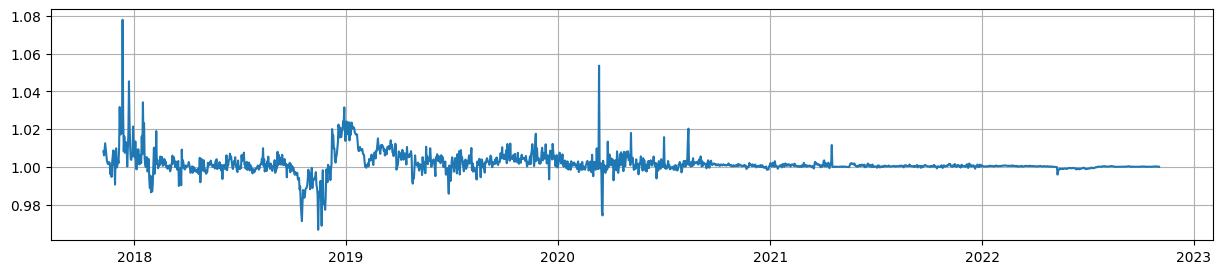

In [4]:
plt.figure(figsize=(15,3))
plt.plot(data.index, data.Close)
plt.grid()
plt.show()

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday',
                                        'Thursday','Friday','Saturday','Sunday'], ordered=True)

def create_features(df, label=None):
    """Create time series features from datetime index."""
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0,300,602,900,1300],
                         labels=['Spring', 'Summer', 'Fall', 'Winter'])
    X = df[['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekday','season']]
    if label:
        y = df[label]
        return X,y
    return X

X,y = create_features(data, label='Close')
features_and_target = pd.concat([X, y], axis=1)

In [6]:
features_and_target.head(3)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Close
Date,,,,,,,,,,
2017-11-09,3,4,11,2017,313,9,45,Thursday,Fall,1.00818
2017-11-10,4,4,11,2017,314,10,45,Friday,Fall,1.00601
2017-11-11,5,4,11,2017,315,11,45,Saturday,Fall,1.00899


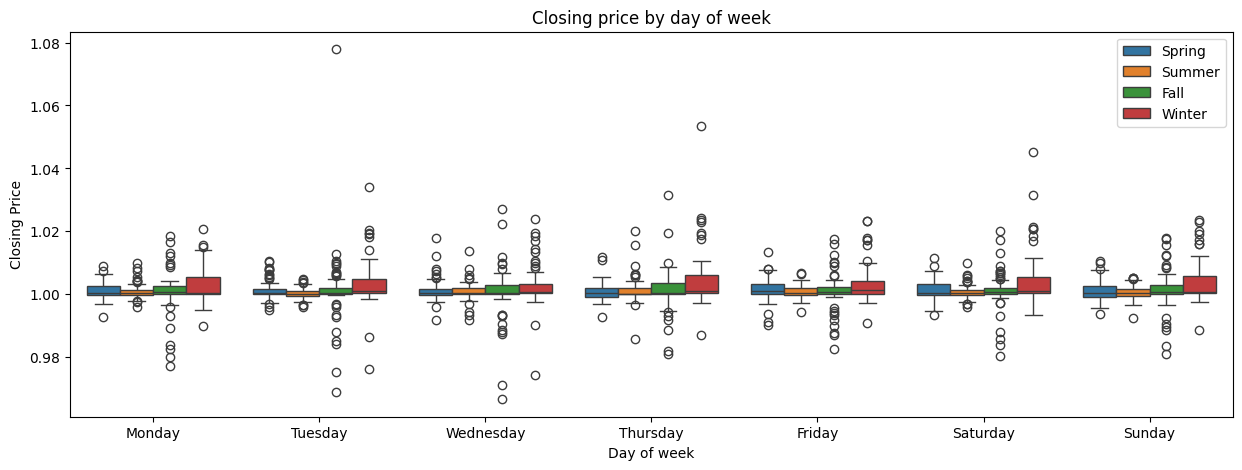

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=features_and_target.dropna(),
           x = 'weekday',
           y = 'Close',
           hue='season',
           ax=ax,
           linewidth=1)
ax.set_title('Closing price by day of week')
ax.set_xlabel("Day of week")
ax.set_ylabel("Closing Price")
ax.legend(bbox_to_anchor=(1,1))
plt.show()

In [8]:
data.index.max()

Timestamp('2022-11-04 00:00:00')

<Axes: title={'center': 'USDT-USD'}, xlabel='Date'>

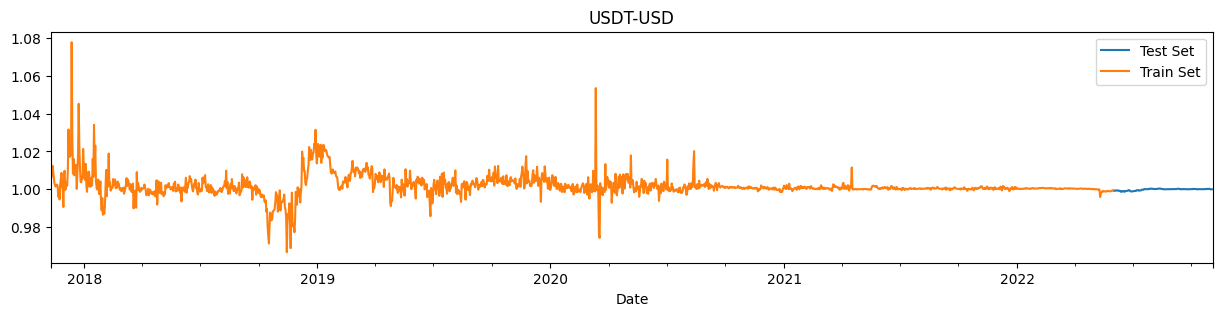

In [9]:
split_data = '2022-06-01'
train = data.loc[data.index < split_data].copy()
test = data.loc[data.index >= split_data].copy()

test.rename(columns={'Close':'Test Set'}).join(train.rename(columns={'Close':'Train Set'}), 
                                               how='outer').plot(figsize=(15,3), title='USDT-USD', ms=1)

In [10]:
prophet_train = train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
prophet_train.head()

,ds,y
0,2017-11-09,1.00818
1,2017-11-10,1.00601
2,2017-11-11,1.00899
3,2017-11-12,1.01247
4,2017-11-13,1.00935


In [11]:
model = Prophet()
model.fit(prophet_train)

12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
prophet_test = test.reset_index().rename(columns={'Date':'ds', 'Close':'y'})

In [13]:
predicts = model.predict(prophet_test)

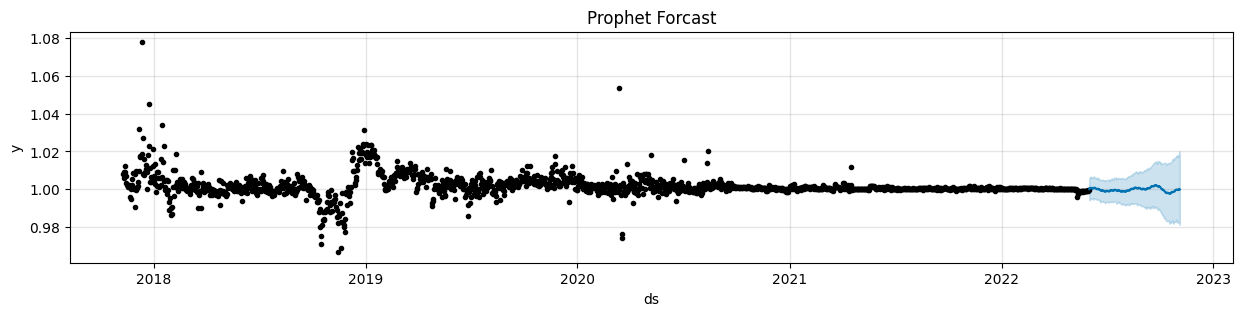

In [14]:
fig, ax = plt.subplots(figsize=(15,3))
fig = model.plot(predicts, ax = ax)
ax.set_title('Prophet Forcast')
plt.show()

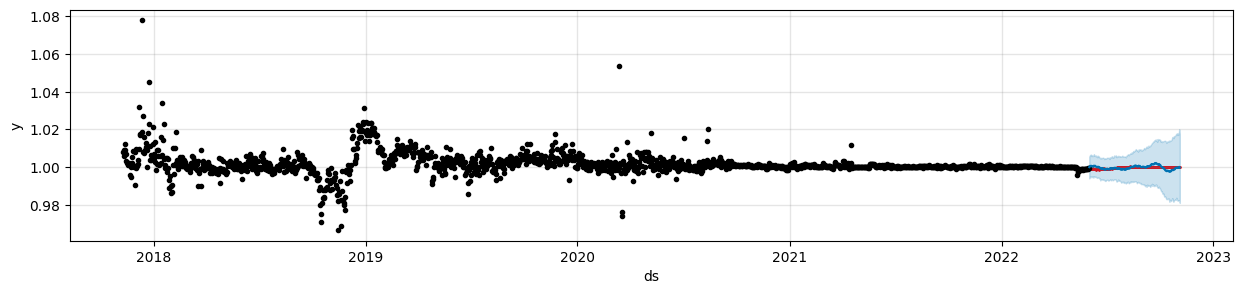

In [15]:
f, ax = plt.subplots(figsize=(15,3))
ax.scatter(test.index, test['Close'], color='r', s=1)
fig = model.plot(predicts, ax=ax)